In [1]:
# Remove input cells at runtime (nbsphinx)
import IPython.core.display as d
d.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# Image cleaning

**Recommended datasample(s):** `gamma1` (dataset used to build the energy model)

**Data level(s):** DL1b (telescope-wise image parameters)

**Description:**

This notebook contains benchmarks and metrics from the _protopipe_ pipeline aimed at the DL1b data level (cleaned and parametrized images).  

**Requirements and steps to reproduce:**

To run this notebook you will need a TRAINING file generated using `protopipe-TRAINING`.  
To get a filled notebook and reproduce these results,

- get the necessary input files using `protopipe-TRAINING`
- execute the notebook with `protopipe-BENCHMARK`

`protopipe-BENCHMARK launch --config_file configs/benchmarks.yaml -n TRAINING/benchmarks_DL1_image-cleaning`

To obtain the list of all available parameters add `--help-notebook`.

**Comparison against CTAMARS:**

- the input file needs to be a merged TRAINING file from the `gamma1` sample,
- reference simtel-files, plots, values and settings can be found [here (please, always refer to the latest version)](https://forge.in2p3.fr/projects/benchmarks-reference-analysis/wiki/Comparisons_between_pipelines).

**Development and testing:**  

As with any other part of _protopipe_ and being part of the official repository, this notebook can be further developed by any interested contributor.  
The execution of this notebook is not currently automatic, it must be done locally by the user _before_ pushing a pull-request.
Please, strip the output before pushing.

## Table of contents
  - [Fraction of events (relative to telescope triggers) that survive a given intensity cut](#Fraction-of-events-(relative-to-telescope-triggers)-that-survive-a-given-intensity-cut)
  - [Image-parameter distributions](#Image-parameter-distributions)
      + [Image intensity from all telescope types](#Image-intensity-from-all-telescope-types)
      + [Image intensity from LST-1](#Image-intensity-from-LST-1)
      + [DL1 Parameters used for energy training from all telecopes](#DL1-Parameters-used-for-energy-training-from-all-telecopes)

## Imports

In [2]:
import os
from pathlib import Path
import warnings

def fxn():
    warnings.warn("runtime", RuntimeWarning)

import tables
import numpy as np
import pandas as pd
import uproot
from scipy.stats import binned_statistic, binned_statistic_2d, cumfreq, percentileofscore
from astropy import units as u
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.pyplot import rc
import matplotlib.style as style
from cycler import cycler
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

from protopipe.pipeline.io import get_camera_names, read_protopipe_TRAINING_per_tel_type
from protopipe.pipeline.utils import add_stats, CTAMARS_radii
from protopipe.benchmarks.utils import string_to_boolean

## Functions

In [3]:
# TODO: move to protopipe.benchmarks.utils
def get_fig_size(ratio=None, scale=None):
    ratio = 4/3. if ratio is None else ratio
    scale = 1.0 if scale is None else scale
    height = 5
    width = height * ratio
    return (width*scale, height*scale)

## Input data
[back to top](#Table-of-contents)

### Protopipe
[back to top](#Table-of-contents)

In [4]:
# Parametrized cell
# Modify these variables according to your local setup outside of the Vagrant Box
analyses_directory = None  # path to the 'analyses' analyses folder
output_directory = Path.cwd() # default output directory for plots
analysis_name = None # Name of the analysis stored in 'analyses_folder'
load_CTAMARS = False  # If True (default), compare to the CTAN analysis done with CTAMARS (Release 2019)
input_filename = None # Name of the file produced with protopipe
CTAMARS_put_directory = None # Path to DL1 CTAMARS data (if load_CTAMARS is True)
apply_image_extraction_status = True # (no effect for single-pass image extractors) If True select only images which pass both passes (enable if load_CTAMARS is True)
min_pixels = 3
min_ellipticity = 0.1
max_ellipticity = 0.6
containment_radius = 0.8 # from 0 to 1 (whole camera)
intensity_cut = 55 # phe
use_seaborn = False # If True import seaborn and apply global settings from config file
plots_scale=None

In [5]:
# Parameters
analyses_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses"
analysis_name = "v0.5.0a1"
load_protopipe_previous = False
analysis_name_2 = "v0.4.0_dev1"
use_seaborn = True
matplotlib_settings = {
    "cmap": "cividis",
    "style": "seaborn-colorblind",
    "rc": {"font_size": 8, "font_family": "Fira Sans"},
    "scale": 1.5,
}
seaborn_settings = {
    "theme": {"style": "whitegrid", "context": "talk"},
    "rc_context": {},
    "rc_style": {"xtick.bottom": True, "ytick.left": True},
}
load_requirements = True
requirements_input_directory = "/Volumes/DataCEA_PERESANO/Data/CTA/requirements/"
load_CTAMARS = True
input_data_CTAMARS = {
    "parent_directory": "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data",
    "TRAINING/DL1": "TRAINING/DL1",
    "TRAINING/DL2": "TRAINING/DL2",
    "DL2": "",
    "DL3": {
        "input_directory": "DL3",
        "input_file": "SubarrayLaPalma_4L15M_south_IFAE_50hours_20190630.root",
    },
    "label": "CTAMARS (2019)",
}
load_EventDisplay = True
input_data_EventDisplay = {
    "input_directory": "/Volumes/DataCEA_PERESANO/Data/CTA/ASWG/Prod3b/Release_2018-12-03/ROOT/North/CTA-Performance-North-20deg_20181203",
    "input_file": "CTA-Performance-North-20deg-S-50h_20181203.root",
    "label": "EventDisplay (2018)",
}
input_filenames = {
    "simtel": "/Users/michele/Applications/ctasoft/tests/data/simtel/gamma_20deg_180deg_run100___cta-prod3-demo-2147m-LaPalma-baseline.simtel.gz",
    "TRAINING_energy_gamma": "TRAINING_energy_tail_gamma_merged.h5",
    "TRAINING_classification_gamma": "TRAINING_classification_tail_gamma_merged.h5",
    "DL2_gamma": "DL2_tail_gamma_merged.h5",
    "DL2_proton": "DL2_energy_tail_gamma_merged.h5",
    "DL2_electron": "DL2_energy_tail_gamma_merged.h5",
    "DL3": "performance_protopipe_Prod3b_CTANorth_baseline_full_array_Zd20deg_180deg_Time50.00h.fits.gz",
}
model_configuration_filenames = {
    "energy": "RandomForestRegressor.yaml",
    "classification": "RandomForestClassifier.yaml",
}
input_filenames_ctapipe = {
    "DL1a_gamma": "events_protopipe_CTAMARS_calibration_1stPass.dl1.h5",
    "DL1a_gamma_2ndPass": "events_protopipe_CTAMARS_calibration_2ndPass.dl1.h5",
}
output_directory = "/Users/michele/Applications/ctasoft/dirac/shared_folder/analyses/v0.5.0a1/benchmarks_results/TRAINING"


In [6]:
# Handle boolean variables (papermill reads them as strings)
[load_CTAMARS, use_seaborn, apply_image_extraction_status] = string_to_boolean([load_CTAMARS, use_seaborn, apply_image_extraction_status])
# Make sure available parameters are not read as strings
intensity_cut = float(intensity_cut)
min_pixels = int(min_pixels)
min_ellipticity = float(min_ellipticity)
max_ellipticity = float(max_ellipticity)
containment_radius = float(containment_radius)

In [7]:
if not analyses_directory or not analysis_name:
    raise ValueError("Input source ill-defined.")

input_directory = Path(analyses_directory) / analysis_name / Path("data/TRAINING/for_energy_estimation/gamma")

if not input_filename:
    try:
        input_filename = input_filenames["TRAINING_energy_gamma"]
    except (NameError, KeyError):
        input_filename = "TRAINING_energy_tail_gamma_merged.h5"

cameras = get_camera_names(input_directory = input_directory,
                           file_name = input_filename)
data = read_protopipe_TRAINING_per_tel_type(input_directory = input_directory,
                                            file_name = input_filename,
                                            camera_names=cameras)

In [8]:
selected_data = {}

if apply_image_extraction_status:

    # Remove from protopipe's data images that did not survive the preliminary image cleaning
    # between the 2 image extraction passes
    for camera in cameras:
        selected_data[camera] = data[camera].query("image_extraction == 1")
        
else:
    
    for camera in cameras:
        selected_data[camera] = data[camera]

### CTA-MARS
[back to top](#Table-of-contents)

In [9]:
if load_CTAMARS:
    
    input_directory_CTAMARS = {}
    input_directory_CTAMARS["parent_directory"] = "/Users/michele/Applications/ctasoft/tests/CTAMARS_reference_data"
    input_directory_CTAMARS["TRAINING/DL1"] = "TRAINING/DL1"
    
    # Get input file path
    if (input_directory_CTAMARS["parent_directory"] is None) or (input_directory_CTAMARS["TRAINING/DL1"] is None):
        raise ValueError("ERROR: CTAMARS data undefined. Please, check the documentation of protopipe-BENCHMARKS.")
    else:

        # read CTAMARS ROOT files
        mars_dl1b_fileName = "check_dl1b.root"
        path_mars_dl1b = Path(input_directory_CTAMARS["parent_directory"]) / input_directory_CTAMARS["TRAINING/DL1"] / mars_dl1b_fileName
        ctamars_dl1b = uproot.open(path_mars_dl1b)

        mars_LST1size_fileName = "LST1_SIZE_distro_gamma1sample.root"
        path_mars_LST1size = Path(input_directory_CTAMARS["parent_directory"]) / input_directory_CTAMARS["TRAINING/DL1"] /  mars_LST1size_fileName
        ctamars_LST1size = uproot.open(path_mars_LST1size)

        # create histograms
        mars_size_npixels_LSTCam = ctamars_dl1b["log10Size_type0"].to_numpy()
        mars_size_npixels_NectarCam = ctamars_dl1b["log10Size_type1"].to_numpy()
        mars_size_WL_LSTCam = ctamars_dl1b["log10Size_WL_type0"].to_numpy()
        mars_size_WL_NectarCam = ctamars_dl1b["log10Size_WL_type1"].to_numpy()
        mars_size_d80_LSTCam = ctamars_dl1b["log10Size_d80_type0"].to_numpy()
        mars_size_d80_NectarCam = ctamars_dl1b["log10Size_d80_type1"].to_numpy()
        mars_size_LST1Cam = ctamars_LST1size["h"].to_numpy()

        # fill camera-wise dictionaries
        CTAMARS = {}
        CTAMARS["LSTCam"] = {"size_npixels": mars_size_npixels_LSTCam, 
                             "size_WL" : mars_size_WL_LSTCam, 
                             "size_d80" : mars_size_d80_LSTCam, 
                             "size_LST1" : mars_size_LST1Cam}
        CTAMARS["NectarCam"] = {"size_npixels": mars_size_npixels_NectarCam, 
                                "size_WL" : mars_size_WL_NectarCam, 
                                "size_d80" : mars_size_d80_NectarCam}

## Plots and benchmarks
[back to top](#Table-of-contents)

In [10]:
# First we check if a _plots_ folder exists already.  
# If not, we create it.
plots_folder = Path(output_directory) / "plots"
plots_folder.mkdir(parents=True, exist_ok=True)

In [11]:
# Plot aesthetics settings

scale = matplotlib_settings["scale"] if plots_scale is None else float(plots_scale)

style.use(matplotlib_settings["style"])
cmap = matplotlib_settings["cmap"]
rc('font', size=matplotlib_settings["rc"]["font_size"])

if matplotlib_settings["style"] == "seaborn-colorblind":
    
    # Change color order to have first ones more readable
    colors_order = ['#0072B2', '#D55E00', '#009E73', '#CC79A7', '#56B4E9', '#F0E442']
    rc('axes', prop_cycle=cycler(color=colors_order))

if use_seaborn:
    import seaborn as sns
    
    sns.set_theme(context=seaborn_settings["theme"]["context"] if "context" in seaborn_settings["theme"] else "talk",
                  style=seaborn_settings["theme"]["style"] if "style" in seaborn_settings["theme"] else "whitegrid",
                  palette=seaborn_settings["theme"]["palette"] if "palette" in seaborn_settings["theme"] else None,
                  font=seaborn_settings["theme"]["font"] if "font" in seaborn_settings["theme"] else "Fira Sans",
                  font_scale=seaborn_settings["theme"]["font_scale"] if "font_scale" in seaborn_settings["theme"] else 1.0,
                  color_codes=seaborn_settings["theme"]["color_codes"] if "color_codes" in seaborn_settings["theme"] else True
                  )
    
    sns.set_style(seaborn_settings["theme"]["style"], rc=seaborn_settings["rc_style"])
    sns.set_context(seaborn_settings["theme"]["context"],
                    font_scale=seaborn_settings["theme"]["font_scale"] if "font_scale" in seaborn_settings["theme"] else 1.0)

### Fraction of events (relative to telescope triggers) that survive a given intensity cut
[back to top](#Table-of-contents)

Multi-cluster cleaning

If the "no-cuts" curve doesn't start at 1, it's because some images were so bad that they couldn't get a valid parametrization and have been recorded with ``hillas_intensity = NaN``.

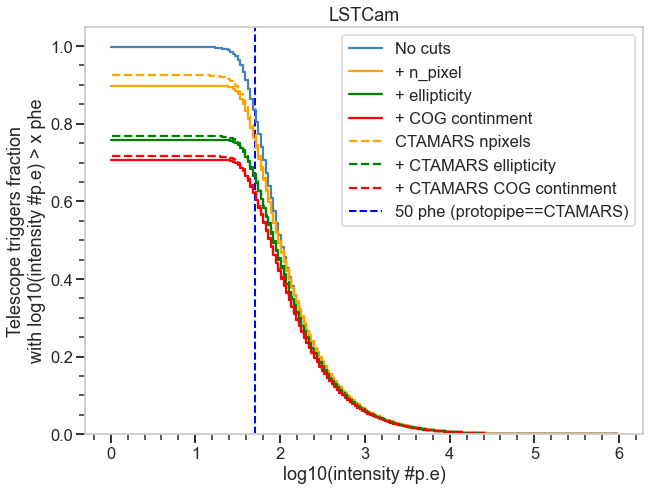

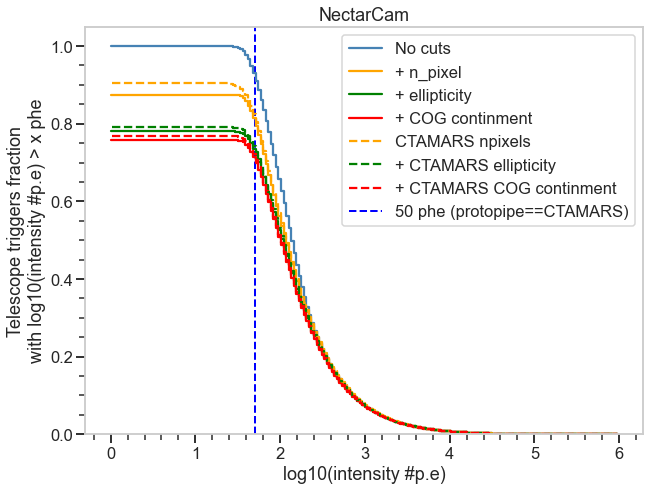

In [12]:
for camera in cameras:
    
    fig = plt.figure(figsize=get_fig_size(ratio=4./3, scale=scale), tight_layout=False)
    plt.xlabel("log10(intensity #p.e)")
    plt.ylabel("Telescope triggers fraction\nwith log10(intensity #p.e) > x phe")
    plt.title(camera)

    #tot_entries = len(selected_data[camera]["hillas_intensity"])
    tot_entries = len(data[camera]["hillas_intensity"])
    
    if load_CTAMARS:
        xbins = CTAMARS[camera]["size_WL"][1]
    else:
        xbins = np.linspace(0,6,100)

    # No cuts
    selected_images = data[camera]
    intensity_hist, xbins = np.histogram(np.log10(selected_images["hillas_intensity"]), bins=xbins)
    plt.plot(xbins[:-1], intensity_hist[::-1].cumsum()[::-1]/tot_entries, drawstyle="steps-post", label="No cuts", 
             color="steelblue"
            )
    
    # Cut in the number of pixels
    selected_images = selected_data[camera].query(f"pixels > {min_pixels}")
    intensity_hist, xbins = np.histogram( np.log10(selected_images["hillas_intensity"]), bins=xbins)
    plt.plot(xbins[:-1], intensity_hist[::-1].cumsum()[::-1]/tot_entries, drawstyle="steps-post", label="+ n_pixel", 
            color="orange"
            )
    
    # Cut in ellipticity
    selected_images = selected_data[camera].query(f"pixels > {min_pixels}\
                                           and hillas_ellipticity > {min_ellipticity}\
                                           and hillas_ellipticity < {max_ellipticity}")
    intensity_hist, xbins = np.histogram( np.log10(selected_images["hillas_intensity"]), bins=xbins)
    plt.plot(xbins[:-1], intensity_hist[::-1].cumsum()[::-1]/tot_entries, drawstyle="steps-post", label="+ ellipticity", 
             color="green"
            )
    
    # Cut in containment radius
    selected_images = selected_data[camera].query(f"pixels > {min_pixels}\
                                           and hillas_ellipticity > {min_ellipticity}\
                                           and hillas_ellipticity < {max_ellipticity}\
                                           and hillas_r < {(CTAMARS_radii(camera)*containment_radius)}")
    intensity_hist, xbins = np.histogram( np.log10(selected_images["hillas_intensity"]), bins=xbins)
    plt.plot(xbins[:-1], intensity_hist[::-1].cumsum()[::-1]/tot_entries, drawstyle="steps-post", label="+ COG continment", 
             color="red"
            )
    
    plt.ylim([0.,1.05])
    ax = plt.gca()
    ylims=ax.get_ylim()
    
    # Plot CTAMARS data

    if load_CTAMARS:
        x = 0.5 * (CTAMARS[camera]["size_WL"][1][1:] + CTAMARS[camera]["size_WL"][1][:-1])
        plt.step(x, CTAMARS[camera]["size_npixels"][0], where='mid', label='CTAMARS npixels', color="orange", linestyle="--")
        plt.step(x, CTAMARS[camera]["size_WL"][0], where='mid', label='+ CTAMARS ellipticity', color="green", linestyle="--")
        plt.step(x, CTAMARS[camera]["size_d80"][0], where='mid', label='+ CTAMARS COG continment', color="red", linestyle="--")
    
        CTAMARS_intensity_cut = 50
        
        plt.vlines(np.log10(CTAMARS_intensity_cut),
               ymin=min(ylims), ymax=max(ylims),
               ls="dashed", lw=2,
               color="blue",
               label=f"{CTAMARS_intensity_cut} phe (protopipe==CTAMARS)")
    else:
        plt.vlines(np.log10(intensity_cut),
               ymin=min(ylims), ymax=max(ylims),
               ls="dashed", lw=2,
               color="blue",
               label=f"{intensity_cut} phe")
    
    
    
    plt.minorticks_on()
    plt.grid()
    plt.legend()

    fig.savefig(plots_folder / f"image_cleaning_eventsAboveIntensity_{camera}_protopipe_{analysis_name}.png")
    
    plt.show()

### Image-parameter distributions
[back to top](#Table-of-contents)

**Notes**  
 - probably better to make bins in true energy
 - the parameters should be at least those that enter the estimators training (here only the pure DL1 are listed)

#### Image intensity from all telescope types
[back to top](#Table-of-contents)

Total number of images = 4064189.0


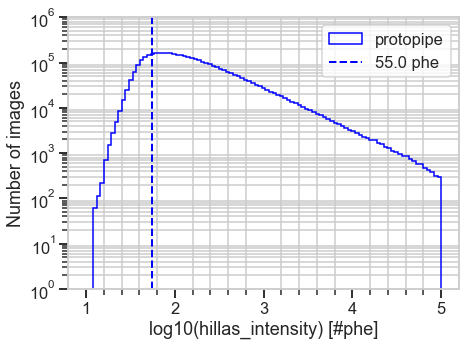

In [13]:
x_bins_edges = np.linspace(1,5,100)
all_telescope_types = pd.concat([selected_data[camera] for camera in cameras])
intensity = all_telescope_types["hillas_intensity"]

fig = plt.figure(figsize=(7, 5), tight_layout=False)

h_protopipe = plt.hist(np.log10(intensity),
                       bins=x_bins_edges,
                       histtype="step",
                       label="protopipe", color="blue")

print(f"Total number of images = {np.sum(h_protopipe[0])}")

plt.xlabel(f"log10(hillas_intensity) [#phe]")
plt.ylabel("Number of images")
plt.yscale('log')
plt.ylim(1, 1.e6)
plt.minorticks_on()
plt.grid(which = "both")

ax = plt.gca()
ylims=ax.get_ylim()
plt.vlines(np.log10(intensity_cut),
           ymin=min(ylims), ymax=max(ylims),
           ls="dashed", lw=2,
           color="blue",
           label=f"{intensity_cut} phe")

plt.legend()
plt.show()

#### Image intensity from LST-1
[back to top](#Table-of-contents)

Total number of images = 492118.0
Total number of images for CTAMARS = 456778.0


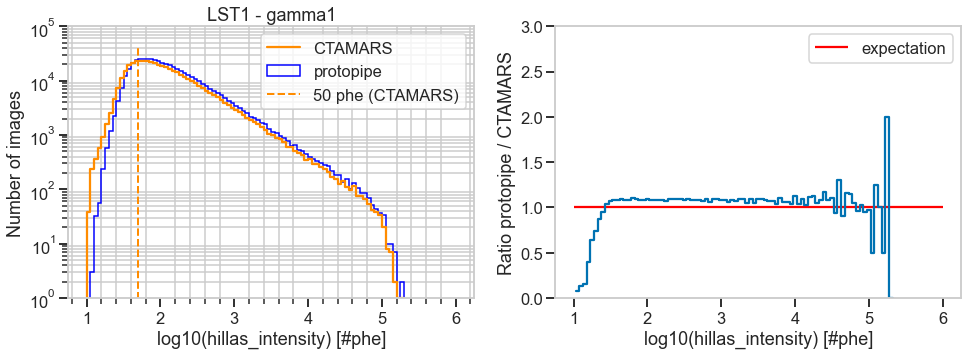

In [14]:
if "LSTCam" in selected_data.keys():

    if load_CTAMARS:
        x_bins_edges = CTAMARS["LSTCam"]["size_LST1"][1]
        CTAMARS_counts = CTAMARS["LSTCam"]["size_LST1"][0]
        fig = plt.figure(figsize=(16, 5), tight_layout=False)
        plt.subplot(1,2,1)
        
        size_LST1 = selected_data["LSTCam"].query("tel_id == 1")["hillas_intensity"]

    else:
        x_bins_edges = np.linspace(1,5,100)
        fig = plt.figure(figsize=(7, 5), tight_layout=False)

    plt.xlabel(f"log10(hillas_intensity) [#phe]")
    plt.ylabel("Number of images")
    plt.title("LST1 - gamma1")
    h_protopipe = plt.hist(np.log10(size_LST1),
                           bins=x_bins_edges,
                           histtype="step",
                           label="protopipe", color="blue")


    print(f"Total number of images = {np.sum(h_protopipe[0])}")

    if load_CTAMARS:
        print(f"Total number of images for CTAMARS = {np.sum(CTAMARS_counts)}")
        plt.step(x_bins_edges[:-1], CTAMARS_counts, where='pre', label='CTAMARS', color="darkorange")

    plt.yscale('log')
    plt.minorticks_on()
    plt.grid(which = "both")

    ax = plt.gca()
    ylims=ax.get_ylim()

    if load_CTAMARS:
        plt.vlines(np.log10(CTAMARS_intensity_cut),
                   ymin=min(ylims), ymax=max(ylims),
                   ls="dashed", lw=2,
                   color="darkorange",
                   label=f"{CTAMARS_intensity_cut} phe (CTAMARS)")
    else:
        plt.vlines(np.log10(intensity_cut),
                   ymin=min(ylims), ymax=max(ylims),
                   ls="dashed", lw=2,
                   color="blue",
                   label=f"{intensity_cut} phe")

    plt.legend()

    plt.ylim(1, 1.e5)

    if load_CTAMARS:
        plt.subplot(1,2,2)

        plt.xlabel(f"log10(hillas_intensity) [#phe]")
        plt.ylabel(f"Ratio protopipe / CTAMARS")
        x = 0.5 * (x_bins_edges[1:] + x_bins_edges[:-1])

        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            fxn()
            plt.step(x, h_protopipe[0]/CTAMARS_counts, where='pre')

        ax = plt.gca()
        xlims=ax.get_xlim()
        xlims=[np.min(x_bins_edges),np.max(x_bins_edges)]
        plt.hlines(1., xlims[0], xlims[1], label="expectation", color='r')
        plt.grid()
        plt.legend()
        plt.ylim(0, 3)

    fig.savefig(plots_folder / f"image_cleaning_hillas_intensity_LST1_gamma1_{camera}_protopipe_{analysis_name}.png")

    plt.show()

else:
    print("No LST camera in this analysis.")

#### DL1 Parameters used for direction reconstruction from all telecopes
[back to top](#Table-of-contents)

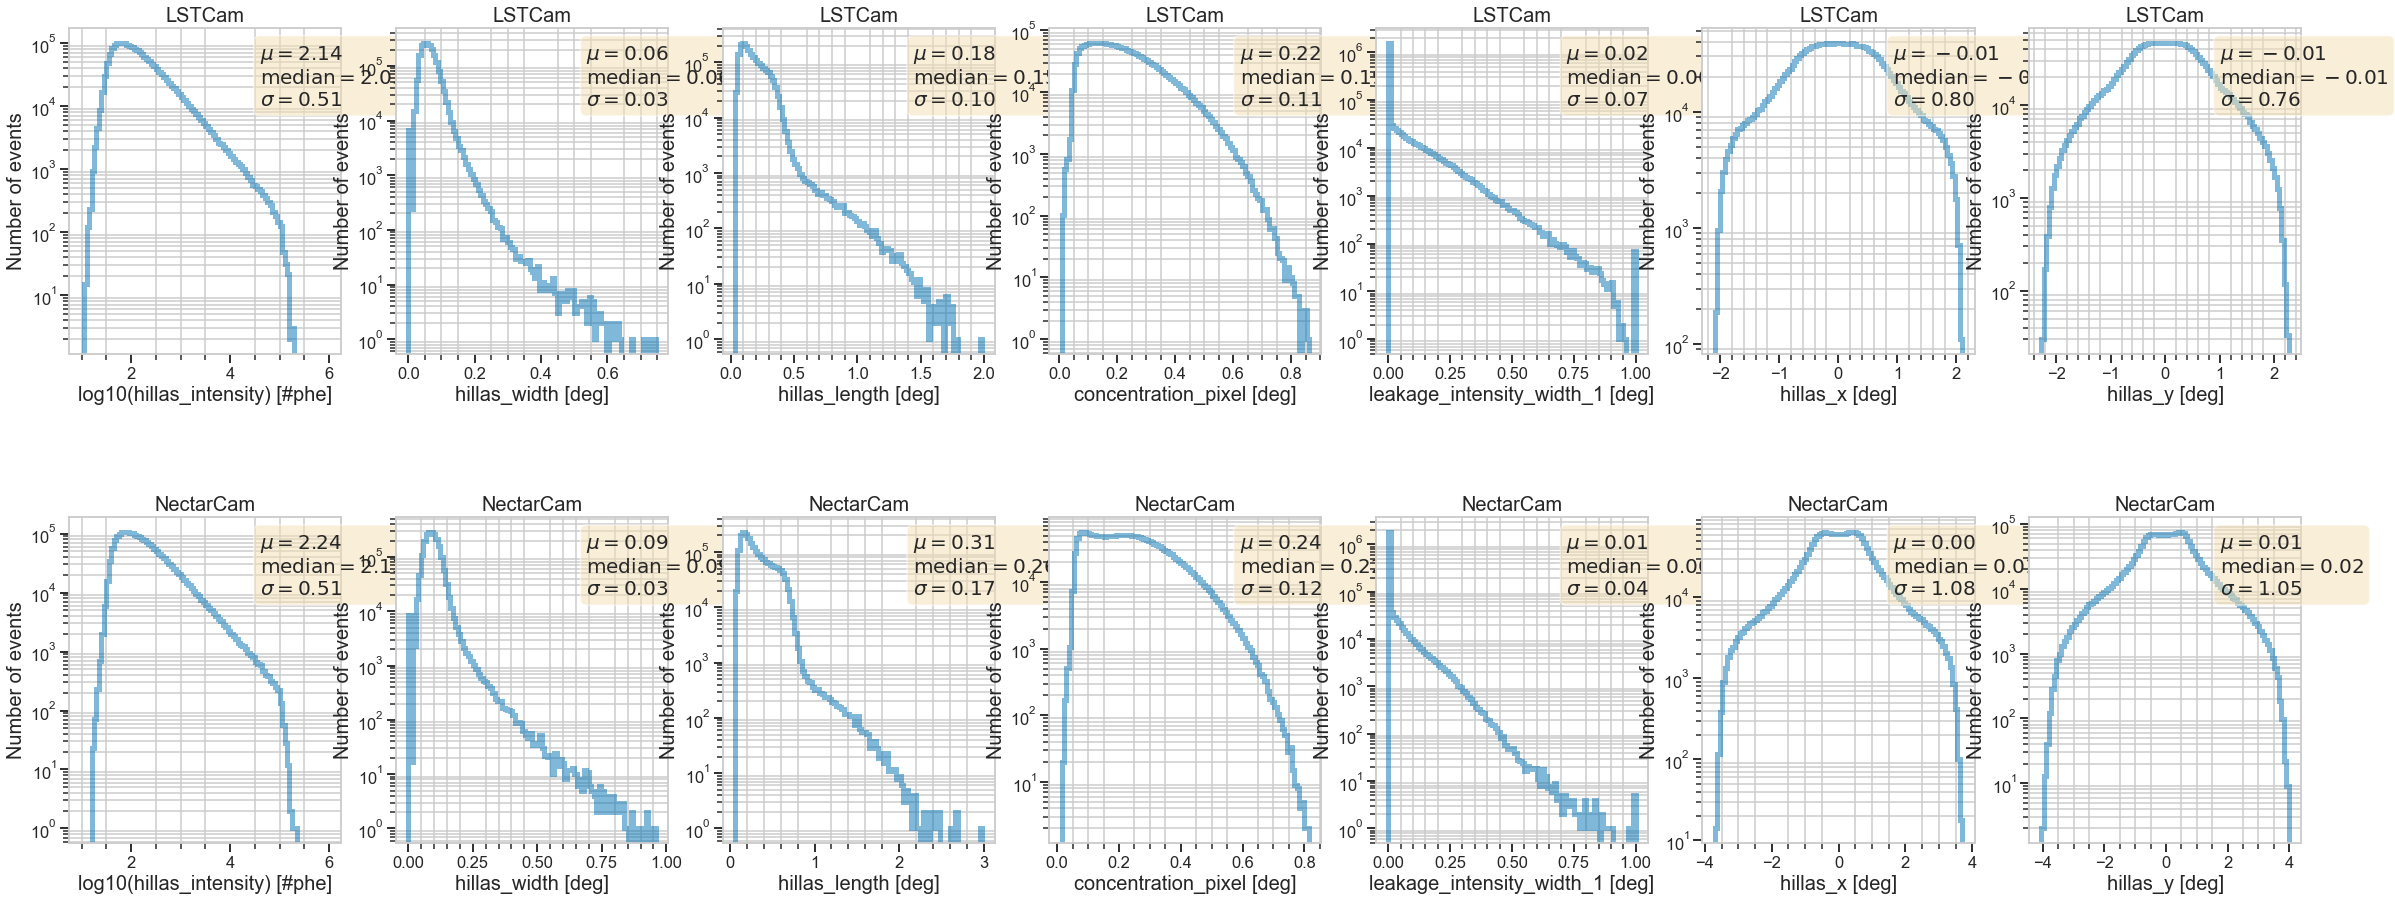

In [15]:
nbins = 100
parameters_to_plot = ["hillas_intensity",
                      "hillas_width",
                      "hillas_length",
                      "concentration_pixel",
                      "leakage_intensity_width_1",
                      "hillas_x",
                      "hillas_y"]

fig, axes = plt.subplots(ncols=len(parameters_to_plot), 
                         nrows=len(cameras), 
                         constrained_layout=False, 
                         figsize = (40, 15))
plt.subplots_adjust(hspace = 0.5)
fontsize=20

for i, camera in enumerate(cameras):
        
    for j, key in enumerate(parameters_to_plot):
        
        axes[i, j].set_ylabel("Number of events", fontsize=fontsize)
        axes[i, j].set_title(camera, fontsize=fontsize)

        if "hillas_intensity" in key:
            axes[i, j].set_xlabel(f"log10({key}) [#phe]", fontsize=fontsize)
            axes[i, j].hist(np.log10(selected_data[camera][key]), 
                            bins=nbins, 
                            range=[1.,6.], 
                            alpha = 0.5, 
                            histtype="step",
                            linewidth=5)
            add_stats(np.log10(selected_data[camera][key]), axes[i, j], x=0.70, y=0.85, fontsize=fontsize)
        else:
            axes[i, j].set_xlabel(f"{key} [deg]", fontsize=fontsize)
            axes[i, j].hist(selected_data[camera][key], 
                            bins=nbins, 
                            alpha = 0.5, 
                            histtype="step",
                            linewidth=5)
            add_stats(selected_data[camera][key], axes[i, j], x=0.70, y=0.85, fontsize=fontsize)
            

        axes[i, j].set_yscale('log')
        axes[i, j].minorticks_on()
        axes[i, j].grid(which = "both")
        
        # Save just the portion _inside_ the second axis's boundaries
        extent = axes[i, j].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        fig.savefig(plots_folder / f"image_cleaning_{key}_gamma1_{camera}_protopipe_{analysis_name}.png", bbox_inches=extent.expanded(1.2, 1.2))

fig.savefig(plots_folder / f"image_cleaning_gamma1_allKeysallCameras_protopipe_{analysis_name}.png")

plt.show()